<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preparing the environment

**Note:** This notebook has to be run using the "Python 2 with Spark" kernel on the ESC403 cluster.  If you have started it with another kernel (e.g., "Python 2") restart it by clicking on the menu bar: *Kernel* $\to$ *Change kernel* $\to$ *Python 2 with Spark*.  The Spark-enabled kernel will take a noticeable time to start; this is expected.

## Graphics and plotting

The following block of code initializes the Python plotting library [matplotlib](http://matplotlib.org/gallery.html) and configures it to show figures embedded in the notebook (as opposed to opening a new window for each figure):

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Set the default size and style of the plot.  (Plots are styled to [look like R's `ggplot`](http://tonysyu.github.io/mpltools/auto_examples/style/plot_ggplot.html) library.)

In [2]:
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 9)

## Spark Context

The *Python 2 with Spark* kernel already performs all necessary steps to properly initialize [Spark][1].  A global [SparkContext][2] is available in variable `sc`:

[1]: http://spark.apache.org/
[2]: http://spark.apache.org/docs/latest/programming-guide.html#initializing-spark

In [3]:
# (already existing) Spark Context
sc

---

# 1. Compute $\pi$ using Map/Reduce

A quasi-Monte Carlo method for computing $\pi$ is the following: we "sample" the area of the unit circle (which is exactly $\pi$) by counting the number of randomly-generated coordinate pairs that fall within the unit circle.  Explicitly:

- pick $N$ random points in the square $[-1,+1] \times [-1,+1]$ (generate both coordinates uniformly at random)
- count the number $P$ of points that fall into the unit circle $\{ (x,y) | x^2+y^2 < 1 \}$
- for large enough $N$, the ratio $P/N$ approximates the area of the unit circle, i.e. $\pi$

A detailed explanation of the method can be found [here](http://mathfaculty.fullerton.edu/mathews/n2003/montecarlopimod.html).

1. Write Python code that runs the above algorithm.  Time its execution: how much does it take to get the result for $N = 16´000´000$?

2. Can you think of a way of parallelizing the algorithm above using Spark's Map/Reduce support?  (*Hint:* it may help to formulate/rewrite the algorithm in terms of `map`/`filter`/`reduce` Python built-ins.)

In [4]:
%%time
import numpy as np
N = 16000000
npoints = 0.
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)
z = x + 1j*y
for w in z:
    if abs(w) < 1:
        npoints += 1       
res = 4*(npoints/N) # Factor of four due to the ratio of the two areas
err = abs(np.pi - res)
print('Calculated Pi: {:.3f}'.format(res))
print('Error: {:.3f}'.format(err))

Calculated Pi: 3.141
Error: 0.000
CPU times: user 6.36 s, sys: 420 ms, total: 6.78 s
Wall time: 6.93 s


In [5]:
%%time

N = 16000000
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)
z = x + 1j*y

temp = filter(lambda x: abs(x) < 1, z)
res = 4.*len(temp)/N
err = abs(np.pi - res)
print('Calculated Pi: {:.3f}'.format(res))
print('Error: {:.3f}'.format(err))

Calculated Pi: 3.142
Error: 0.000
CPU times: user 5.72 s, sys: 417 ms, total: 6.14 s
Wall time: 6.17 s


In [6]:
from random import random

N = 16000000

def point(_):
    x = random()
    y = random()
    return (x, y)

In [8]:
%%time
arr = range(N)
partitions = 16
rdd = sc.parallelize(arr, partitions)
intermediate1 = rdd.map(point)
intermediate2 = intermediate1.filter(lambda (x, y): x**2 + y**2 < 1)
P = intermediate2.count()
res = 4.*P/N
err = abs(np.pi - res)
print('Calculated Pi: {:.3f}'.format(res))
print('Error: {:.3f}'.format(err))

Calculated Pi: 3.142
Error: 0.000
CPU times: user 856 ms, sys: 336 ms, total: 1.19 s
Wall time: 7.85 s


# 2. Word count

1. Write a PySpark function to count occurrences of each word in a given file; the function should return a Python dictionary, mapping a word (a string) to the (integer) count of its occurrences.  In this context, a "word" is defined as a non-empty sequence of letters; i.e., words are separated by white space and punctuation signs. 

2. Print the top-10 words of each test dataset below.

The ESC403 cluster provides two test datasets:

* the complete works by William Shakespeare, available as `hdfs:///data/shakespeare.txt`
* "Oliver Twist" by Charles Dickens, available as `hdfs:///data/dickens.txt`

*Hint:* You can make a Spark RDD containing the *lines* of a text file with the following code::

    text = sc.textFile('hdfs:///data/dickens.txt')

("Word count" plays the role of the introductory exercise "Hello, world!" in the Map/Reduce context; it was popularized by the [original Map/Reduce paper by Dean and Ghemawat](https://research.google.com/archive/mapreduce-osdi04.pdf).)

In [17]:
import re
punctuation = re.compile(r'[^\w]', re.M)

from operator import add

def wordcount(filename):
    lines1 = sc.textFile('hdfs://' + filename)
    lines2 = lines1.map(lambda line: punctuation.sub(' ', line).lower())
    words1 = lines2.flatMap(lambda line: line.lower().split())
    words2 = words1.map(lambda word: (word, 1))
    cnts = words2.reduceByKey(add)
    return cnts

In [30]:
%%time
dickens = '/data/dickens.txt'
shakespeare = '/data/shakespeare.txt'

wc1 = wordcount(dickens)
wc2 = wordcount(shakespeare)


print('Oliver Twist word counts: {}'.format(wc1.takeOrdered(5, lambda x: -x[1])))
print '\n'
print('Complete works by William Shakespeare word counts: {}'.format(wc2.takeOrdered(5, lambda x: -x[1])))
print '\n'

Oliver Twist word counts: [(u'the', 9806), (u'and', 5498), (u'to', 4041), (u'of', 3996), (u'a', 3843)]


Complete works by William Shakespeare word counts: [(u'the', 27843), (u'and', 26847), (u'i', 22538), (u'to', 19882), (u'of', 18307)]


CPU times: user 27 ms, sys: 291 µs, total: 27.3 ms
Wall time: 1.46 s


# 3. Word differencies

How can we find word usage dissimilarity?  Building upon the previous exercise, find and print the top $N$ words occurring in one dataset that do not occur in the other.

In [31]:
def normalise_by_total_count(wc):
    tot_words = wc.count()
    wfreq = wc.map(lambda (k, v): (k, 100.0*v/tot_words))
    return wfreq

wf1 = normalise_by_total_count(wc1)
wf2 = normalise_by_total_count(wc2)
wf = wf1.join(wf2)
wf.filter(lambda (k, (v1, v2)): v1 - v2 > 0.1).take(5)

[(u'looking', (1.3617750690410437, 0.17076929484776543)),
 (u'locked', (0.1809351490334254, 0.008330209504769044)),
 (u'bates', (0.8951528425864204, 0.045816152276229746)),
 (u'pocket', (0.5999428625845158, 0.1457786663334583)),
 (u'rolled', (0.12379773354918579, 0.004165104752384522))]

# 4. Test Zipf's law

Zipf's law asserts that, when words in a corpus are ranked by frequency, frequency is (approximately) inversely proportional to rank.  For example, the most frequent word (rank 1) will be approximately 5 times as frequent as the 5th ranked one.

Test Zipf's law by computing and plotting the relative frequency of the 100 most frequent words in each dataset.

In [38]:
import numpy as np
xmax = 1000
y = 1.0/np.arange(1, xmax)

top_words_with_count1 = wc1.top(xmax, lambda(k, v): v)
top_freq1 = float(top_words_with_count1[0][1])
freq1 = np.array([(occurences / top_freq1) for (word, occurences) in top_words_with_count1])

top_words_with_count2 = wc2.top(xmax, lambda(k, v): v)
top_freq2 = float(top_words_with_count2[0][1])
freq2 = np.array([(occurences / top_freq2) for (word, occurences) in top_words_with_count2])

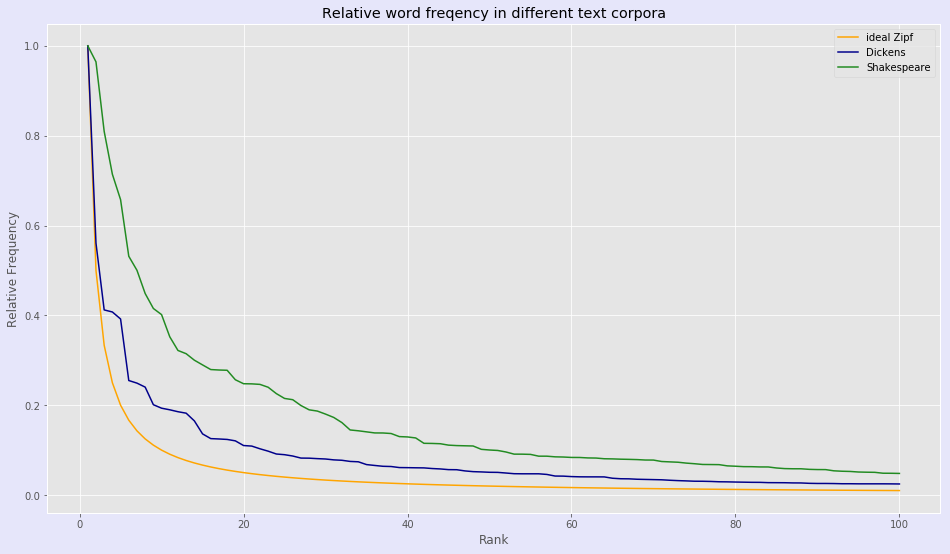

In [39]:
xmax_display = 100
xs = np.arange(1, xmax_display+1)

plt.figure(facecolor='lavender')
plt.plot(xs, y[:xmax_display], color='orange', label='ideal Zipf')
plt.plot(xs, freq1[:xmax_display], color='darkblue', label='Dickens')
plt.plot(xs, freq2[:xmax_display], color='forestgreen', label='Shakespeare')
plt.legend()
plt.xlabel('Rank')
plt.ylabel('Relative Frequency')
plt.title('Relative word freqency in different text corpora')
plt.show()